# utils for Symmetry Projected Edge Correlation

In [1]:
from parse import parse
import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import os
import pickle

def parseLine(line, obs, id):
    # print(line)
    r = parse("iter = {} sign = ({},{}) z2 = ({},{}) edgeCorrelator = ({},{}) edgeZ2Correlator = ({},{}) CDW = ({},{}) CDWM4 = ({},{})\n", line)
    # print(r)
    if r is None:
        print("error in parse", line)
        return False
    sign = complex(eval(r[1]), eval(r[2]))
    z2 = complex(eval(r[3]), eval(r[4]))
    edgeCorrelator = complex(eval(r[5]), eval(r[6]))
    edgeZ2Correlator = complex(eval(r[7]), eval(r[8]))
    cdw = complex(eval(r[9]), eval(r[10]))
    cdwm4 = complex(eval(r[11]), eval(r[12]))
    obs["sign"][id] = sign
    obs["z2"][id] = z2
    obs["edgeCorrelator"][id] = edgeCorrelator
    obs["edgeZ2Correlator"][id] = edgeZ2Correlator
    obs["cdw"][id] = cdw
    obs["cdwm4"][id] = cdwm4
    return True

def readFile(filename):
    obsList = {"sign": [], "z2": [], "edgeCorrelator": [], "edgeZ2Correlator": [], "cdw": [], "cdwm4": []}
    params = ()
    count = 0
    with open(filename, 'r', encoding='UTF-8') as f: 
        flag = False
        for l in f.readlines():
            if not flag:
                if l[:4] == "iter":
                    flag = True
                    parseLine(l, obsList, count)
                    count += 1
                if l[:4] == "Lx =":
                    # print(l)
                    r = parse("Lx = {:d} LTau = {:d} dt = {} V = {} seed = {} nthreads = {} delta = {} boundary = {} evaluationLength = {:d}\n", l)
                    # print(r)
                    params = (r[0], r[1], eval(r[2]), eval(r[3]), eval(r[6]))
                    evaluationLen = r[8]
                    # print(evaluationLen)
                    for k in obsList:
                        obsList[k] = np.zeros(evaluationLen, dtype=complex)
            else:
                if l[:4] == "iter":
                    flagNew = parseLine(l, obsList, count)
                    count += 1
                    if not flagNew:
                        return obsList, params
                elif l[:7] == "=== End":
                    return obsList, params
                else:
                    print(l, "error invalid line")
    print("warning not finished\n")
    return obsList, params

# \sum d1 / \sum d2
def JackKnifeRatio(d1, d2):
    l = len(d1)
    jacks = np.zeros(l, dtype=complex)
    for i in range(l):
        mean1 = np.mean(d1) - d1[i]/l
        mean2 = np.mean(d2) - d2[i]/l
        jacks[i] = mean1/mean2
    return (np.mean(jacks).real, np.std(jacks)*np.sqrt(l-1))

def JackKnifeBinderRatio(s2, s4, signs):
    l = len(s2)
    jacks = np.zeros(l, dtype=complex)
    for i in range(l):
        mean2 = np.mean(s2) - s2[i]/l
        mean4 = np.mean(s4) - s4[i]/l
        meanSign = np.mean(signs) - signs[i]/l
        jacks[i] = (meanSign * mean4) / (mean2 * mean2)
    return (np.mean(jacks).real, np.std(jacks)*np.sqrt(l-1))


def biningAndJackknife(data):
    NBins = 100
    tmp = {}
    tmp["obsSign"] = data["sign"]
    z2 = data["z2"]
    tmp["obsZ2"] = tmp["obsSign"] * z2
    eCorr = data["edgeCorrelator"]
    eCorrZ = (data["edgeZ2Correlator"])
    tmp["obsZ2plus"] = 0.5 * (tmp["obsSign"] * (1.0 + z2))
    tmp["obsZ2minus"] = 0.5 * (tmp["obsSign"] * (1.0 - z2))
    tmp["obsEdgeCorrelator"] = tmp["obsSign"] * eCorr
    tmp["obsEdgeCorrelatorPlus"] = 0.5 * (tmp["obsSign"] * (eCorr + eCorrZ))
    tmp["obsEdgeCorrelatorMinus"] = 0.5 * (tmp["obsSign"] * (eCorr - eCorrZ))
    tmp["obsCDW"] = tmp["obsSign"] * (data["cdw"])
    tmp["obsCDWM4"] = tmp["obsSign"] * (data["cdwm4"])

    r = {}
    for k in tmp:
        l = len(tmp[k])
        curArray = np.array(tmp[k]).reshape((l//NBins, NBins))
        m = np.mean(curArray, axis=1)
        tmp[k] = m

    r["obsSign"] = (np.mean(tmp["obsSign"]).real, np.std(tmp["obsSign"]))
    r["obsZ2"] = JackKnifeRatio(tmp["obsZ2"], tmp["obsSign"])
    r["obsZ2Plus"] = JackKnifeRatio(tmp["obsZ2plus"], tmp["obsSign"])
    r["obsZ2Minus"] = JackKnifeRatio(tmp["obsZ2minus"], tmp["obsSign"])
    r["obsEdgeCorrelator"] = JackKnifeRatio(tmp["obsEdgeCorrelator"], tmp["obsSign"])
    r["obsEdgeCorrelatorPlus"] = JackKnifeRatio(tmp["obsEdgeCorrelatorPlus"], tmp["obsZ2plus"])
    r["obsEdgeCorrelatorMinus"] = JackKnifeRatio(tmp["obsEdgeCorrelatorMinus"], tmp["obsZ2minus"])
    r["obsCDW"] = JackKnifeRatio(tmp["obsCDW"], tmp["obsSign"])
    r["obsCDWM4"] = JackKnifeRatio(tmp["obsCDWM4"], tmp["obsSign"])
    r["obsBinning"] = JackKnifeBinderRatio(tmp["obsCDW"], tmp["obsCDWM4"], tmp["obsSign"])
    # print(r["obsSign"])
    # print(r["obsBinning"])
    # print((r["obsCDWM4"][0]) / r["obsCDW"][0]**2, r["obsCDWM4"][1] / r["obsCDW"][0]**2)

    return r


## $\Delta = t$, sign problem and $\mathbb{Z}_2$ expectation

In [2]:
with open('./data/data_L8-18_V1.0-7.0_len832k+.pkl', 'rb') as f:
    data = pickle.load(f)

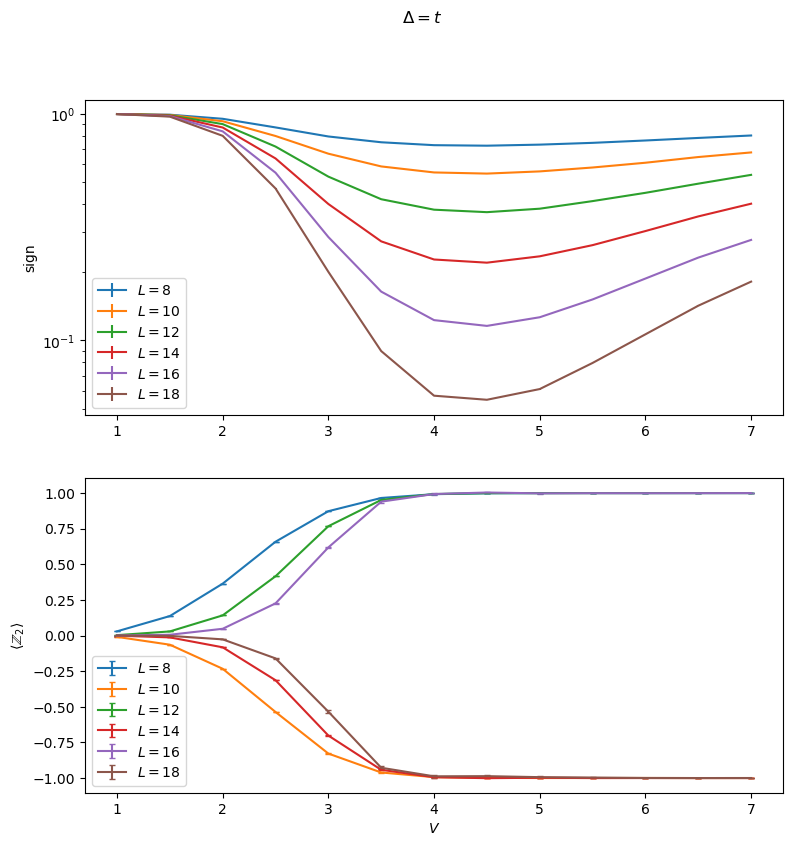

In [13]:
Vs = np.arange(1.0, 7.5, 0.5)
Ls = np.arange(8, 19, 2)

fig, axs = plt.subplots(2, 1, figsize=(9, 9))

for L in [8, 10, 12, 14, 16, 18]:
    signs = []
    signsStd = []
    z2PlusSigns = []
    z2PlusSignsStd = []
    z2MinusSigns = []
    z2MinusSignsStd = []
    for V in Vs:
        # print("L = {}, V = {}".format(L, V))
        # obs, params = getChainDataFromFile(L, V)
        # r = biningAndAnalysis(obs)
        r = data[(L, V)]
        signs.append(r["obsSign"][0])
        signsStd.append(r["obsSign"][1])
        z2PlusSigns.append(r["obsZ2"][0])
        z2PlusSignsStd.append(r["obsZ2"][1])

    axs[0].errorbar(Vs, signs, yerr=signsStd, label=r"$L = {}$".format(L))

    axs[1].errorbar(Vs, z2PlusSigns, yerr=z2PlusSignsStd, label=r"$L = {}$".format(L), capsize=2)

axs[0].set_ylabel(r"sign")
    # axs[0].set_ylim(0, 1.0)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_ylabel(r"$\left<\mathbb{Z}_2 \right>$")
# axs[1].set_ylim(0, 1.0)
# axs[1].set_yscale("log")
axs[1].set_xlabel(r"$V$")
axs[1].legend()

fig.suptitle("$\Delta = t$")
plt.legend()
plt.show()


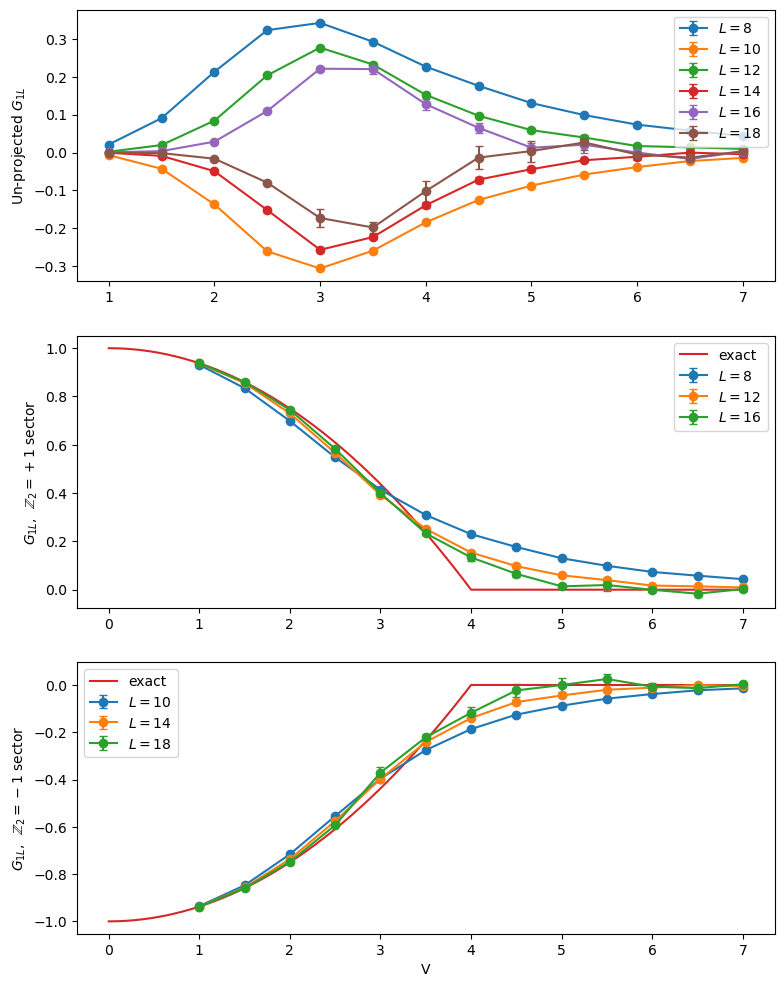

In [21]:
Vs = np.arange(1.0, 7.5, 0.5)

fig, axs = plt.subplots(3, 1, figsize=(9, 12))
cut = len(Vs)

for L in [8, 10, 12, 14, 16, 18]:
    signs = []
    # signsStd = []
    z2PlusSigns = []
    # z2PlusSignsStd = []
    z2MinusSigns = []
    # z2MinusSignsStd = []
    eCorr = []
    eCorrStd = []

    eCorrZ2Plus = []
    eCorrZ2PlusStd = []
    eCorrZ2Minus = []
    eCorrZ2MinusStd = []
    for V in Vs:
        r = data[(L, V)]
        # signs.append(r["obsSign"][0])
        # # signsStd.append(r["obsSign"][1])
        # z2PlusSigns.append(r["obsZ2plus"][0].real)
        # # z2PlusSignsStd.append(r["obsZ2plus"][1])
        # z2MinusSigns.append(r["obsZ2minus"][0].real)
        # z2MinusSignsStd.append(r["obsZ2minus"][1])
        eCorr.append(r["obsEdgeCorrelator"][0])
        eCorrStd.append(r["obsEdgeCorrelator"][1])
        eCorrZ2Plus.append(r["obsEdgeCorrelatorPlus"][0])
        eCorrZ2PlusStd.append(r["obsEdgeCorrelatorPlus"][1])
        eCorrZ2Minus.append(r["obsEdgeCorrelatorMinus"][0])
        eCorrZ2MinusStd.append(r["obsEdgeCorrelatorMinus"][1])

    
        
    eCorrStd = np.clip(np.abs(eCorrStd), 0, 1)
    eCorrZ2PlusStd = np.clip(np.abs(eCorrZ2PlusStd), 0, 1)
    eCorrZ2MinusStd = np.clip(np.abs(eCorrZ2MinusStd), 0, 1)


    axs[0].errorbar(Vs, eCorr, yerr=eCorrStd, label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    if L in [8, 12, 16]:
        axs[1].errorbar(Vs[:cut], eCorrZ2Plus[:cut], yerr=eCorrZ2PlusStd[:cut], label=r"$L = {}$".format(L), marker='o', capsize=3)
    
    if L in [10, 14, 18]:
        axs[2].errorbar(Vs[:cut], eCorrZ2Minus[:cut], yerr=eCorrZ2MinusStd[:cut], label=r"$L = {}$".format(L), marker='o', capsize=3)
    # axs[2].set_yscale("log")

xs = np.arange(0.0, 7.0, 0.01)
f = lambda x: 1.0 - ((x/4.0)**2) if x <= 4.0 else 0.0
ys = np.array([f(x) for x in xs])
axs[1].plot(xs, ys, label="exact")
axs[2].plot(xs, -ys, label="exact")

axs[0].set_ylabel(r"Un-projected $G_{1L}$")
axs[0].legend()

axs[1].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=+1$ sector")
# axs[1].set_ylim(-1, 1.0)
axs[1].legend()

axs[2].set_ylabel(r"$G_{1L}$,  $\mathbb{Z}_2=-1$ sector")
axs[2].set_xlabel(r"V")
# axs[2].set_ylim(-1, 1.0)
axs[2].legend()
plt.legend()
plt.show()
